In [4]:
import numpy as np
import matplotlib.pyplot as plt
#from numba import njit

In [18]:
def generate_sample(alpha, beta, n_samples, sigma_2=1):
    m = lambda x: np.sin(1 / (x / 3 + 0.1))

    X = np.random.beta(a=alpha, b=beta, size=n_samples)
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_2), size=n_samples)
    Y = m(X) + epsilon

    response = Y
    covariate = X
    return covariate, response

def estimate_parameters(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith

    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2

    #W = np.diag(quartic_kernel((X - x) / h))
    #X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
    #beta_x = np.inv(X.T @ W @ X) @ X.T @ W @ Y

    def beta_est(x_array):
        beta_x = []
        for (idx, x) in enumerate(x_array):
            W = np.diag(quartic_kernel((X - x) / h))
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])

            # Regulaize for inversion stability
            reg = 1e-5
            I_n = np.eye(np.shape(X_matrix)[1])
            beta_x.append(np.linalg.inv(X_matrix.T @ W @ X_matrix + reg*I_n) @ X_matrix.T @ W @ Y)
        return np.array(beta_x) # beta_x
    
    return beta_est

x, y = generate_sample(0.1, 0.1, 10000, 0.1)

beta_fct = estimate_parameters(x, y, 0.1, p=2)
p = np.linspace(0, 1, 100)
beta_values = beta_fct(p) 

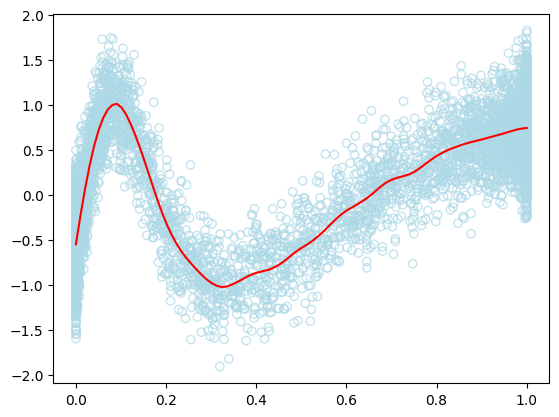

In [19]:
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='lightblue', alpha=0.7)
plt.plot(p, beta_values[:, 0], color="red", label=r"fit ($\hat\beta_0)$")
#plt.plot(p, beta_values[:, 1], color="orange", label = r"derivative ($\hat\beta_1)$")
#plt.plot(p, 2*beta_values[:, 2], color="yellow", label = r"second ($\hat\beta_2)$")

In [20]:
def estimate_sigma_theta_old(covariate, response, bandwith = 0.1, N_blocks = 10):

    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p = 4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)    #index j corresponds to the j-th block, then access array of evaluations

    sigma_2_hat, theta_22 = 0, 0
    # Compute second derivative [recheck]
    theta_22 = np.sum([np.sum([2 * m_j_x_i[2]**2 for m_j_x_i in m_j_list[j]]) for j in range(len(covariate_blocks))])
    theta_22 /= size

    """ 
        second_derivs = 2 * betas_at_points[:, 2]
        theta_22 += np.sum(second_derivs**2)

        preds = np.sum(betas_at_points * np.column_stack([X_block**k for k in range(betas_at_points.shape[1])]), axis=1)
        sigma_2_num += np.sum((Y_block - preds)**2)

        theta_22 /= size
        sigma_2_hat = sigma_2_num / (size - 5*N_blocks)

    """

    return sigma_2_hat, theta_22

def est_h_IMSE(sigma_2_hat, theta_22, size):
    # Note that support is [0, 1] (beta distribution)
    h_IMSE = size**(-1/5) * ((35 * sigma_2_hat * 1) / theta_22)**(1/5)
    
    return h_IMSE

In [ ]:
""" def estimate_sigma_theta(covariate, response, bandwith = 0.1, N_blocks = 10):

    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p = 4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)    #index j corresponds to the j-th block, then access array of evaluations

    sigma_2_hat, theta_22 = 0, 0

    theta_22, sigma_2_hat = 0, 0

    for j in range(len(covariate_blocks)):
        X_block = covariate_blocks[j]
        Y_block = response_blocks[j]
        for idx, xi in enumerate(X_block):
            yi = Y_block[idx]
            
            # index of xi in the sorted covariate array
            k = np.where(X_sorted == xi)[0][0]
            beta_row = m_j_list[j][k]   # coefficients for xi under block j
            
            m_val = beta_row[0]
            m_dd_val = 2 * beta_row[2]
            
            theta_22 += m_val * m_dd_val
            sigma_2_hat += (yi - m_val)**2

    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)


    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)

    return sigma_2_hat, theta_22 """

""" def estimate_sigma_theta_quick(covariate, response, bandwith=0.1, N_blocks=10):

    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)
    X_sorted = covariate[sorted_indices]
    Y_sorted = response[sorted_indices]

    # Split blocks
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate coefficients for each block evaluated at all Xi
    m_j_list = []
    for j in range(N_blocks):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p=4)
        betas_all_X = beta_est(X_sorted)   # shape (n, 5) : coefficients for each Xi
        m_j_list.append(betas_all_X)

    theta_sum, sigma_sum = 0.0, 0.0

    # Vectorized block loop
    for j in range(N_blocks):
        start = j * block_size
        end = (j + 1) * block_size if j < N_blocks - 1 else size

        # grab the betas for Xi in block j
        betas_block = m_j_list[j][start:end]   # shape (block_size, 5)
        X_block = X_sorted[start:end]
        Y_block = Y_sorted[start:end]

        m_val = betas_block[:, 0]       # fitted values
        m_dd_val = 2 * betas_block[:, 2]  # second derivative

        theta_sum += np.sum(m_val * m_dd_val)
        sigma_sum += np.sum((Y_block - m_val) ** 2)

    theta_22 = theta_sum / size
    sigma_2_hat = sigma_sum / (size - 5 * N_blocks)

    return sigma_2_hat, theta_22
 """

Works:

In [ ]:
def estimate_parameters_worked(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith

    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2

    def beta_est(x_array):
        beta_x = []
        for (idx, x) in enumerate(x_array):
            W = np.diag(quartic_kernel((X - x) / h))
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])

            # Regulaize for inversion stability
            reg = 1e-5
            I_n = np.eye(np.shape(X_matrix)[1])
            beta_x.append(np.linalg.inv(X_matrix.T @ W @ X_matrix + reg*I_n) @ X_matrix.T @ W @ Y)
        return np.array(beta_x) # beta_x
    
    return beta_est

def estimate_sigma_theta_worked(covariate, response, bandwith = 0.1, N_blocks = 10):

    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters_worked(covariate_blocks[j], response_blocks[j], bandwith, p = 4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)    #index j corresponds to the j-th block, then access array of evaluations

    sigma_2_hat, theta_22 = 0, 0

    for j in range(len(covariate_blocks)):
        X_block = covariate_blocks[j]
        Y_block = response_blocks[j]
        for idx, xi in enumerate(X_block):
            yi = Y_block[idx]
            
            # index of xi in the sorted covariate array
            k = np.where(X_sorted == xi)[0][0]
            beta_row = m_j_list[j][k]   # coefficients for xi under block j
            
            m_val = beta_row[0]
            m_dd_val = 2 * beta_row[2]
            
            theta_22 += m_val * m_dd_val
            sigma_2_hat += (yi - m_val)**2

    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)


    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)

    return sigma_2_hat, theta_22

In [21]:
""" def estimate_parameters_quick(covariate, response, bandwith, p=1, reg = 0.0):
    X = np.asarray(covariate)
    Y = np.asarray(response)
    h = bandwith

    quartic_kernel = lambda u: (np.abs(u) <= 1) * (15/16) * (1 - u**2)**2

    def beta_est(x_array):
        beta_x = []
        for x in x_array:
            u = (X - x) / h
            w = quartic_kernel(u)   # shape (n,)

            # weighted design matrix
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])

            # compute weighted cross-products without forming W
            XTWX = (X_matrix.T * w) @ X_matrix
            XTWY = (X_matrix.T * w) @ Y

            # regularization
            XTWX_reg = XTWX + reg * np.eye(XTWX.shape[0])

            # solve instead of inverting
            beta = np.linalg.solve(XTWX_reg, XTWY)
            beta_x.append(beta)

        return np.array(beta_x)

    return beta_est """

""" def estimate_parameters_quick(covariate, response, bandwith, p=1, reg=1e-5):  # Changed default reg
    X = np.asarray(covariate)
    Y = np.asarray(response)
    h = bandwith
    
    quartic_kernel = lambda u: (np.abs(u) <= 1) * (15/16) * (1 - u**2)**2
    
    def beta_est(x_array):
        beta_x = []
        for x in x_array:
            u = (X - x) / h
            w = quartic_kernel(u)
            
            # Add small epsilon to weights to avoid complete zeros
            w = w + 1e-10
            
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
            
            XTWX = (X_matrix.T * w) @ X_matrix
            XTWY = (X_matrix.T * w) @ Y
            
            XTWX_reg = XTWX + reg * np.eye(XTWX.shape[0])
            
            # Check condition number before solving
            if np.linalg.cond(XTWX_reg) > 1e10:
                print(f"Warning: Ill-conditioned matrix at x={x}")
            
            beta = np.linalg.solve(XTWX_reg, XTWY)
            beta_x.append(beta)
        
        return np.array(beta_x)
    
    return beta_est """

""" def estimate_parameters_quick_1(covariate, response, bandwith, p=1, reg=1e-5):
    X = np.asarray(covariate).flatten()  # Ensure 1D
    Y = np.asarray(response).flatten()   # Ensure 1D
    h = bandwith
    
    quartic_kernel = lambda u: (np.abs(u) <= 1) * (15/16) * (1 - u**2)**2
    
    def beta_est(x_array):
        beta_x = []
        for x in x_array:
            u = (X - x) / h
            w = quartic_kernel(u)
            
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
            
            XTWX = (X_matrix.T * w) @ X_matrix
            XTWY = (X_matrix.T * w) @ Y
            
            XTWX_reg = XTWX + reg * np.eye(XTWX.shape[0])
            
            beta = np.linalg.solve(XTWX_reg, XTWY)
            beta_x.append(beta)
        
        return np.array(beta_x)
    
    return beta_est """

""" def estimate_sigma_theta_quick_quick(covariate, response, bandwith=0.1, N_blocks=10):#, reg=0.0):

    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)
    X_sorted = covariate[sorted_indices]
    Y_sorted = response[sorted_indices]

    # Split blocks
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate coefficients for each block evaluated at all Xi
    m_j_list = []
    for j in range(N_blocks):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p=4)#, reg=reg)
        betas_all_X = beta_est(X_sorted)   # shape (n, 5) : coefficients for each Xi
        m_j_list.append(betas_all_X)

    theta_sum, sigma_sum = 0.0, 0.0

    # Vectorized block loop
    for j in range(N_blocks):
        start = j * block_size
        end = (j + 1) * block_size if j < N_blocks - 1 else size

        # grab the betas for Xi in block j
        betas_block = m_j_list[j][start:end]   # shape (block_size, 5)
        X_block = X_sorted[start:end]
        Y_block = Y_sorted[start:end]

        m_val = betas_block[:, 0]       # fitted values
        m_dd_val = 2 * betas_block[:, 2]  # second derivative

        theta_sum += np.sum(m_val * m_dd_val)
        sigma_sum += np.sum((Y_block - m_val) ** 2)

    theta_22 = theta_sum / size
    sigma_2_hat = sigma_sum / (size - 5 * N_blocks)

    return sigma_2_hat, theta_22 """

""" def estimate_parameters_claude(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith
    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2
    
    # Pre-compute constants
    reg = 1e-5
    n_features = p + 1
    I_n = np.eye(n_features)
    
    def beta_est(x_array):
        n_points = len(x_array)
        beta_x = np.empty((n_points, n_features, Y.shape[1] if Y.ndim > 1 else 1))
        
        for idx, x in enumerate(x_array):
            # Vectorized weight computation
            w = quartic_kernel((X - x) / h)
            
            # Build design matrix (vectorized power computation)
            X_centered = X - x
            X_matrix = np.column_stack([X_centered**p_ for p_ in range(n_features)])
            
            # Weighted matrices using broadcasting instead of diagonal matrix
            W_sqrt = np.sqrt(w)
            X_weighted = X_matrix * W_sqrt[:, np.newaxis]
            Y_weighted = Y * W_sqrt[:, np.newaxis] if Y.ndim > 1 else Y * W_sqrt
            
            # Solve weighted least squares (more stable than manual inversion)
            XtWX = X_weighted.T @ X_weighted + reg * I_n
            XtWY = X_weighted.T @ Y_weighted
            
            beta_x[idx] = np.linalg.solve(XtWX, XtWY).reshape(-1, beta_x.shape[2])


    return beta_est """

""" def estimate_sigma_theta_claude(covariate, response, bandwith=0.1, N_blocks=10):

    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)
    X_sorted = covariate[sorted_indices]
    Y_sorted = response[sorted_indices]

    # Split blocks
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate coefficients for each block evaluated at all Xi
    m_j_list = []
    for j in range(N_blocks):
        beta_est = estimate_parameters_claude(covariate_blocks[j], response_blocks[j], bandwith, p=4)
        betas_all_X = beta_est(X_sorted)   # shape (n, 5) : coefficients for each Xi
        m_j_list.append(betas_all_X)

    theta_sum, sigma_sum = 0.0, 0.0

    # Vectorized block loop
    for j in range(N_blocks):
        start = j * block_size
        end = (j + 1) * block_size if j < N_blocks - 1 else size

        # grab the betas for Xi in block j
        betas_block = m_j_list[j][start:end]   # shape (block_size, 5)
        X_block = X_sorted[start:end]
        Y_block = Y_sorted[start:end]

        m_val = betas_block[:, 0]       # fitted values
        m_dd_val = 2 * betas_block[:, 2]  # second derivative

        theta_sum += np.sum(m_val * m_dd_val)
        sigma_sum += np.sum((Y_block - m_val) ** 2)

    theta_22 = theta_sum / size
    sigma_2_hat = sigma_sum / (size - 5 * N_blocks)

    return sigma_2_hat, theta_22
 """   

def estimate_parameters_worked_v2(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith
    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2
    
    def beta_est(x_array):
        n = len(x_array)
        n_params = p + 1
        beta_x = np.empty((n, n_params))
        reg = 1e-5
        
        # Precompute powers of X if p > 0
        X_powers = np.column_stack([X**p_ for p_ in range(p + 1)])
        
        for idx, x in enumerate(x_array):
            # Vectorized weight computation
            weights = quartic_kernel((X - x) / h)
            sqrt_W = np.sqrt(weights)
            
            # Weighted design matrix: sqrt(W) * X_matrix
            X_diff_powers = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
            X_weighted = sqrt_W[:, None] * X_diff_powers
            Y_weighted = sqrt_W * Y
            
            # Solve via Cholesky (faster than full inverse)
            XtWX = X_weighted.T @ X_weighted
            XtWX[np.diag_indices_from(XtWX)] += reg
            
            beta_x[idx] = np.linalg.solve(XtWX, X_weighted.T @ Y_weighted)
        
        return beta_x
   
    return beta_est

def estimate_sigma_theta_worked_v2(covariate, response, bandwith = 0.1, N_blocks = 10):

    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters_worked_v2(covariate_blocks[j], response_blocks[j], bandwith, p = 4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)    #index j corresponds to the j-th block, then access array of evaluations

    sigma_2_hat, theta_22 = 0, 0

    for j in range(len(covariate_blocks)):
        X_block = covariate_blocks[j]
        Y_block = response_blocks[j]
        for idx, xi in enumerate(X_block):
            yi = Y_block[idx]
            
            # index of xi in the sorted covariate array
            k = np.where(X_sorted == xi)[0][0]
            beta_row = m_j_list[j][k]   # coefficients for xi under block j
            
            m_val = beta_row[0]
            m_dd_val = 2 * beta_row[2]
            
            theta_22 += m_val * m_dd_val
            sigma_2_hat += (yi - m_val)**2

    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)


    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)

    return sigma_2_hat, theta_22

In [24]:
#sigma_2_hat, theta_22 = estimate_sigma_theta_claude(covariate=x, response=y, bandwith=0.1, N_blocks=5)
sigma_2_hat, theta_22 = estimate_sigma_theta_worked_v2(covariate=x, response=y, bandwith=0.2, N_blocks=10)

Computations time:
1. 12m 0.1s [estimate_sigma_theta + estimate_parameters]
2. 11m 47.4s [estimate_sigma_theta_quick + estimate_parameters]
3. [estimate_sigma_theta + estimate_parameters_quick]
4. 23s 0.8ms [estimate_sigma_theta_quick + estimate_parameters_quick --> estimate_parameters_quick_quick]

In [25]:
print(sigma_2_hat, theta_22)

h_IMSE = est_h_IMSE(sigma_2_hat, theta_22, size=10000)


print(h_IMSE)

5.743425636970536e-05 -6.339410083467872e-05
nan


C:\Users\Philipp\AppData\Local\Temp\ipykernel_5724\212793487.py:46: RuntimeWarning: invalid value encountered in scalar power
  h_IMSE = size**(-1/5) * ((35 * sigma_2_hat * 1) / theta_22)**(1/5)
